In [3]:
from rdkit import Chem
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True


In [4]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    # viewer.addPropertyLabels("atom","","")

    # for i, at in enumerate(mol):
    #     default = {"stick": {'color': 'black'}}
    #     viewer.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer



In [5]:
mol = Chem.SDMolSupplier('org_4.sdf')[0]
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
def get_torsions(mol_list):
    atom_counter = 0
    torsionList = []
    dihedralList = []
    for m in mol_list:
        torsionSmarts = '[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]'
        torsionQuery = Chem.MolFromSmarts(torsionSmarts)
        matches = m.GetSubstructMatches(torsionQuery)
        conf = m.GetConformer()
        for match in matches:
            idx2 = match[0]
            idx3 = match[1]
            bond = m.GetBondBetweenAtoms(idx2, idx3)
            jAtom = m.GetAtomWithIdx(idx2)
            kAtom = m.GetAtomWithIdx(idx3)
            for b1 in jAtom.GetBonds():
                if (b1.GetIdx() == bond.GetIdx()):
                    continue
                idx1 = b1.GetOtherAtomIdx(idx2)
                for b2 in kAtom.GetBonds():
                    if ((b2.GetIdx() == bond.GetIdx())
                            or (b2.GetIdx() == b1.GetIdx())):
                        continue
                    idx4 = b2.GetOtherAtomIdx(idx3)
                    # skip 3-membered rings
                    if (idx4 == idx1):
                        continue
                    # skip torsions that include hydrogens
                    #                     if ((m.GetAtomWithIdx(idx1).GetAtomicNum() == 1)
                    #                         or (m.GetAtomWithIdx(idx4).GetAtomicNum() == 1)):
                    #                         continue
                    if m.GetAtomWithIdx(idx4).IsInRing():
                        torsionList.append(
                            (idx4 + atom_counter, idx3 + atom_counter, idx2 + atom_counter, idx1 + atom_counter))
                        break
                    else:
                        torsionList.append(
                            (idx1 + atom_counter, idx2 + atom_counter, idx3 + atom_counter, idx4 + atom_counter))
                        break
                break

        atom_counter += m.GetNumAtoms()
    return torsionList


In [7]:
rotable_bonds = get_torsions([mol])

In [8]:
print(rotable_bonds)

[(0, 7, 9, 14), (4, 13, 7, 0), (6, 8, 12, 1), (14, 9, 12, 1)]


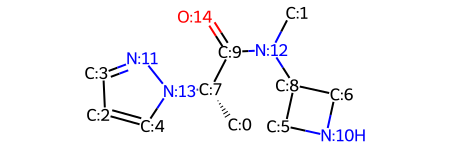

In [9]:
def show_atom_number(mol, label):
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp(label, str(i))
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol
show_atom_number(mol, 'molAtomMapNumber')

In [22]:
from rdkit.Chem import rdMolTransforms
import copy

def SetDihedral(conf, atom_idx, new_vale):
    rdMolTransforms.SetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3], new_vale)


def GetDihedral(conf, atom_idx):
    return rdMolTransforms.GetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3])

def GetBondLength(conf, atom_idx):
    return rdMolTransforms.GetBondLength(conf, atom_idx[0], atom_idx[1])

def SetBondLength(conf, atom_idx, new_vale):
    return rdMolTransforms.SetBondLength(conf, atom_idx[0], atom_idx[1], new_vale)

def GetAngle(conf, atom_idx):
    return rdMolTransforms.GetAngleDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2])

def SetAngle(conf, atom_idx, new_vale):
    return rdMolTransforms.SetAngleDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], new_vale)


def apply_changes(mol, values, rotable_bonds):
    opt_mol = copy.deepcopy(mol)
    #     opt_mol = add_rdkit_conformer(opt_mol)

    # apply rotations
    [SetDihedral(opt_mol.GetConformer(), rotable_bonds[r], values[r]) for r in range(len(rotable_bonds))]

    #     # apply transformation matrix
    #     rdMolTransforms.TransformConformer(opt_mol.GetConformer(), GetTransformationMatrix(values[:6]))

    return opt_mol

def apply_changes_bond_length(mol, values, bond_idx):
    opt_mol = copy.deepcopy(mol)
    [SetBondLength(opt_mol.GetConformer(), bond_idx[r], values[r]) for r in range(len(bond_idx))]
    return opt_mol

def apply_changes_angle(mol, values, bond_idx):
    opt_mol = copy.deepcopy(mol)
    [SetAngle(opt_mol.GetConformer(), bond_idx[r], values[r]) for r in range(len(bond_idx))]

    return opt_mol

In [20]:
# change bond length (N:12 C:8)
org_blen = GetBondLength(mol.GetConformer(), [12, 8])
print(org_blen)
new_mol = apply_changes_bond_length(mol, [1.4], [[12, 8]])
viewer = MolTo3DView(new_mol, size=(600, 300), style='stick')
viewer.show()

1.4599099287284814


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
# change angle degree (N:12 C:8 C:6)
org_angle = GetAngle(mol.GetConformer(), [12, 8, 6])
print(org_angle)
new_mol = apply_changes_angle(mol, [180], [[12, 8, 6]])
viewer = MolTo3DView(new_mol, size=(600, 300), style='stick')
viewer.show()

117.27975490642386


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [32]:
# change dihedral angle degree (N:12 C:8 C:6)
org_dangle = GetDihedral(mol.GetConformer(), [12, 8, 6, 10])
print(org_dangle)
new_mol = apply_changes(mol, [270], [[12, 8, 6, 10]])
viewer = MolTo3DView(new_mol, size=(600, 300), style='stick')
viewer.show()

141.9401901773152


ValueError: bond (j,k) must not belong to a ring

In [ ]:
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(mol.GetConformer(), rot_bond))
print(org_angle)
import numpy as np
org_angle = np.array(org_angle)

In [ ]:
org_angle[0] -= 30
# org_angle[1] += 60
new_mol = apply_changes(mol, org_angle, rotable_bonds)

In [ ]:
viewer = MolTo3DView(new_mol, size=(600, 300), style='stick')
viewer.show()

In [ ]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

In [ ]:
# get conformer
coords = mol.GetConformer().GetPositions()
print(coords)

In [ ]:
coords2 = new_mol.GetConformer().GetPositions()
print(coords2)

In [ ]:
import torch
from torchmdnet.datasets import PCQM4MV2

raw_path = '/sharefs/sharefs-skfeng/Denoising/data/pcq/'
pcq_data = PCQM4MV2(raw_path)

In [ ]:
import numpy as np
MOL_LST = np.load("mol_iter_all.npy", allow_pickle=True)

In [ ]:
idx = 19999
mol = MOL_LST[idx]
h_mol = Chem.AddHs(mol)
atom_num = mol.GetNumAtoms()
h_coords = pcq_data[idx].pos
all_atom_num = pcq_data[idx].pos.shape[0]

In [ ]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

In [ ]:
from rdkit.Geometry import Point3D
coord_conf = h_mol.GetConformer()
for i in range(atom_num, all_atom_num):
    x,y,z = h_coords[i]
    coord_conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))

In [ ]:
rotable_bonds = get_torsions([h_mol])
print(rotable_bonds)
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(h_mol.GetConformer(), rot_bond))
print(org_angle)
org_angle = np.array(org_angle)
org_angle -= 60
print(org_angle)
# org_angle[1] += 60
new_h_mol = apply_changes(h_mol, org_angle, rotable_bonds)
viewer = MolTo3DView(new_h_mol, size=(600, 300), style='stick')
viewer.show()

In [ ]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

In [ ]:
from tqdm import tqdm
total_num = len(MOL_LST)
h_mol_lst = []
for idx in tqdm(range(total_num)):
    mol = MOL_LST[idx]
    h_mol = Chem.AddHs(mol)
    atom_num = mol.GetNumAtoms()
    h_coords = pcq_data[idx].pos
    all_atom_num = pcq_data[idx].pos.shape[0]
    coord_conf = h_mol.GetConformer()
    for i in range(atom_num, all_atom_num):
        x,y,z = h_coords[i]
        coord_conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))
    h_mol_lst.append(h_mol)
    

In [ ]:
np.save('h_mol_lst.npy', h_mol_lst)

In [ ]:
viewer = MolTo3DView(h_mol_lst[200], size=(600, 300), style='stick')
viewer.show()

In [ ]:
viewer = MolTo3DView(MOL_LST[200], size=(600, 300), style='stick')
viewer.show()

In [ ]:
total_num = len(pcq_data)
MOL_LST2 = np.load("h_mol_lst.npy", allow_pickle=True)

In [ ]:
from tqdm import tqdm
abnormal_mol = []
abnormal_idx = []
for idx in tqdm(range(total_num)):
    mol = MOL_LST2[idx]
    atom_num = mol.GetNumAtoms()
    all_atom_num = pcq_data[idx].pos.shape[0]
    if atom_num != all_atom_num:
        abnormal_idx.append(idx)
        abnormal_mol.append(mol)


In [ ]:
abnormal_idx

In [ ]:
viewer = MolTo3DView(MOL_LST2[1001], size=(600, 300), style='stick')
viewer.show()

In [ ]:
viewer = MolTo3DView(MOL_LST[1001], size=(600, 300), style='stick')
viewer.show()

In [ ]:
show_atom_number(MOL_LST[abnormal_idx[10]], 'molAtomMapNumber')